In [1]:
import re
import pandas as pd
from pathlib import Path
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000

In [2]:
data_dir = Path('./dataset')
raw_targets = [p.read_text(encoding='utf-8-sig') for p in (data_dir / 'target').glob('*.txt')]
raw_others = [p.read_text(encoding='utf-8-sig') for p in (data_dir / 'sother').glob('*.txt')]

print(f"# targets: {len(raw_targets)} \n# others: {len(raw_others)}")

# targets: 11 
# others: 17


In [3]:
# Cleaning first part of text obtained from project guttenberg
def clean_guttenberg_header(text):
  ex = r"The Project Gutenberg eBook.*?\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

# Cleaning out the footer extra info added by project gutteneberg
def clean_guttenberg_footer(text):
  ex = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

def clean_guttenberg(text):
  clean = clean_guttenberg_header(text)
  clean = clean_guttenberg_footer(clean)
  return clean

In [4]:
cleaned_targets = [clean_guttenberg(text) for text in raw_targets]
cleaned_others = [clean_guttenberg(text) for text in raw_others]

In [5]:
def sentence_chunk(text, chunk_size=100, overlap=50):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents if len(sent.text.strip()) > 1]
    chunks = []
    for i in range(0, len(sentences), chunk_size - overlap):
        chunk = ' '.join(sentences[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

In [6]:
# Define chunk size
chunk_size = 100
overlap = 0
target_chunks = []
other_chunks = []

for text in cleaned_targets:
    target_chunks.extend(sentence_chunk(text, chunk_size = chunk_size, overlap=overlap))

for text in cleaned_others:
    other_chunks.extend(sentence_chunk(text, chunk_size = chunk_size, overlap=overlap))



In [7]:
# Print the number of chunks for each list
print(f"Number of chunks in cleaned_targets: {len(target_chunks)}")
print(f"Number of chunks in cleaned_others: {len(other_chunks)}")

Number of chunks in cleaned_targets: 515
Number of chunks in cleaned_others: 663


In [8]:
other_chunks[0]

'\n\n\n\n\n[Illustration]\n\n\n\n\nALL THINGS CONSIDERED\n\nBY\nG. K. CHESTERTON\n\n\n\n\n_First Published (Eighth Edition) at IS. net September 2nd 1915_\n\n _Ninth Edition    November  1915_\n\n\n\n\n CONTENTS\n\n THE CASE FOR THE EPHEMERAL\n COCKNEYS AND THEIR JOKES\n THE FALLACY OF SUCCESS\n ON RUNNING AFTER ONE’S HAT\n THE VOTE AND THE HOUSE\n CONCEIT AND CARICATURE\n PATRIOTISM AND SPORT\n AN ESSAY ON TWO CITIES\n FRENCH AND ENGLISH\n THE ZOLA CONTROVERSY\n OXFORD FROM WITHOUT\n WOMAN\n THE MODERN MARTYR\n ON POLITICAL SECRECY\n EDWARD VII. AND SCOTLAND\n THOUGHTS AROUND KOEPENICK\n THE BOY\n LIMERICKS AND COUNSELS OF PERFECTION\n ANONYMITY AND FURTHER COUNSELS\n ON THE CRYPTIC AND THE ELLIPTIC\n THE WORSHIP OF THE WEALTHY\n SCIENCE AND RELIGION\n THE METHUSELAHITE\n SPIRITUALISM\n THE ERROR OF IMPARTIALITY\n PHONETIC SPELLING\n HUMANITARIANISM AND STRENGTH\n WINE WHEN IT IS RED\n DEMAGOGUES AND MYSTAGOGUES\n THE “EATANSWILL GAZETTE”\n FAIRY TALES\n TOM JONES AND MORALITY\n THE M

In [9]:
def prepare_data(text):
  doc = nlp(text)
  normalized_tokens = []
  word_lengths=[]
  sent_lengths=[]

  for token in doc:
    if token.is_punct or token.is_space:
      continue
    token_text = token.text.strip().lower()
    normalized_tokens.append(token_text)
    word_lengths.append(len(token_text))
  normalized_text = ' '.join(normalized_tokens)

  sent_lengths=[len(sent) for sent in doc.sents]
  return normalized_text, word_lengths, sent_lengths

In [10]:
preprocessed_target_chunks = [prepare_data(chunk) for chunk in target_chunks]
preprocessed_other_chunks = [prepare_data(chunk) for chunk in other_chunks]

In [11]:
preprocessed_target_chunks[0][0]

'the secret adversary by agatha christie to all those who lead monotonous lives in the hope that they may experience at second hand the delights and dangers of adventure contents prologue chapter i. the young adventurers ltd chapter ii mr whittington ’s offer chapter iii a set back chapter iv who is jane finn chapter v. mr julius p. hersheimmer chapter vi a plan of campaign chapter vii the house in soho chapter viii the adventures of tommy chapter ix tuppence enters domestic service chapter x. enter sir james peel edgerton chapter xi julius tells a story chapter xii a friend in need chapter xiii the vigil chapter xiv a consultation chapter xv tuppence receives a proposal chapter xvi further adventures of tommy chapter xvii annette chapter xviii the telegram chapter xix jane finn chapter xx too late chapter xxi tommy makes a discovery chapter xxii in downing street chapter xxiii a race against time chapter xxiv julius takes a hand chapter xxv jane ’s story chapter xxvi mr brown chapter 

#### Feature Engineering

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

all_chunks = preprocessed_target_chunks + preprocessed_other_chunks
corpus = [chunk[0] for chunk in all_chunks]
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(corpus)

CountVectorizer()

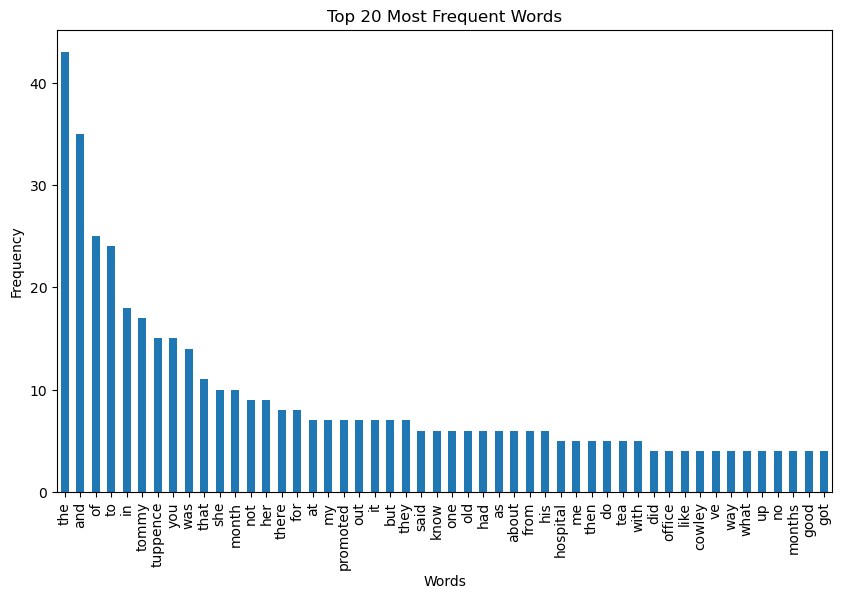

In [13]:
import matplotlib.pyplot as plt

bow_matrix = bow_vectorizer.transform([preprocessed_target_chunks[1][0]]) 
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.head()
word_counts = bow_df.sum(axis=0)
sorted_word_counts = word_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_word_counts.head(50).plot(kind='bar')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [14]:
bow_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = []
y = []

for item in preprocessed_target_chunks:
    X.append(bow_vectorizer.transform([item[0]]).toarray().flatten())
    y.append(1)


for item in preprocessed_other_chunks:
    X.append(bow_vectorizer.transform([item[0]]).toarray().flatten())
    y.append(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

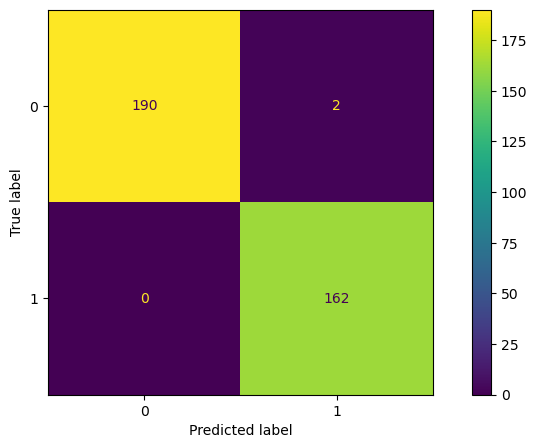

In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
